# Intro
I highschool I was one of the worst in chemistry and physi. Hovever I decided to check what can I achieved only by ML techniques. This notebook have non-chemistry approach: I'll use basic chemistry knowledge, a bit research and ML.

# Preprocessing
I'll merge `train` and `test` to `merged` for preprocessing . As dataset is small (and require small computational power), we'l use **boosting methods**, so preprocessing will be adjusted to their requirements.  Let's take a look on data:

In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import confusion_matrix, make_scorer
from scipy.stats import boxcox, skew, normaltest, boxcox_normmax
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from matplotlib import pyplot
import seaborn as sns
sns.set(color_codes=True)
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Load datasets. 
# "merged" dataset to make preprocessing at one go.
train = pd.read_csv('../input/train.csv', index_col=0)
test = pd.read_csv('../input/test.csv', index_col=0)
merged = pd.concat([train, test], axis=0, ignore_index=True)
print ("merged set: ", merged.head())

merged set:     bandgap_energy_ev  formation_energy_ev_natom  lattice_angle_alpha_degree  \
0             3.4387                     0.0680                     90.0026   
1             2.9210                     0.2490                     90.0186   
2             2.7438                     0.1821                     90.9688   
3             3.3492                     0.2172                     89.9888   
4             1.3793                     0.0505                     89.9960   

   lattice_angle_beta_degree  lattice_angle_gamma_degree  \
0                    90.0023                     90.0017   
1                    89.9980                    120.0025   
2                    91.1228                     30.5185   
3                    90.0119                    120.0017   
4                    90.0006                    119.9893   

   lattice_vector_1_ang  lattice_vector_2_ang  lattice_vector_3_ang  \
0                9.9523                8.5513                9.1775   
1        

In [2]:
print ("missing values: \n",merged.isnull().sum(axis =0) )

missing values: 
 bandgap_energy_ev             600
formation_energy_ev_natom     600
lattice_angle_alpha_degree      0
lattice_angle_beta_degree       0
lattice_angle_gamma_degree      0
lattice_vector_1_ang            0
lattice_vector_2_ang            0
lattice_vector_3_ang            0
number_of_total_atoms           0
percent_atom_al                 0
percent_atom_ga                 0
percent_atom_in                 0
spacegroup                      0
dtype: int64


The only missing values are values to predict, and we'll solve regression problem . As chemistry-beginner I'll google and think how to bring out valuable information from the following features:
* percent_atoms
* number_of_total_atoms
* spacegroup
* lattice_vectors, lattice_angle_xxx_degrees

Based in them we'll create new features. It will be examined later if newly created features will be usefull. 

## Percent_atoms, number_of_total_atoms
Firstly let's take a look on our old good highschool friend- periodic table :) Seems that density and atomic mass might be helpful. What can we calculate:
1. **ratio** of each element to another;
2. **how many atoms** of given element occurs in molecule;
3. **molecule mass** (based on atomic mass and number of given atoms)

**Take a note.** `Percent_atom` columns don't include oxygen. According to the [formula](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors) oxygen atoms are 3/5 (60%) of total atoms, and Ga + In + Al are the rest (40%)).

In [3]:
# to avoid problems with dividig by 0, I'll use dutom division function
def division (divident, divisor):
    return (divident/ divisor).replace([np.inf, -np.inf, np.nan], 0)  

# 1 atio of each element to another;
merged['Al_to_In'] = division( merged['percent_atom_al'], merged['percent_atom_in'] )
merged['In_to_Ga'] = division( merged['percent_atom_in'] , merged['percent_atom_ga'])
merged['Ga_to_Al'] = division( merged['percent_atom_ga'],merged['percent_atom_al']) 

# 2 how many atoms of given element occurs in molecule;
merged['O_atoms']= merged['number_of_total_atoms'] * 0.6
merged['Al_atoms'] = merged['number_of_total_atoms'] * 0.4 * merged['percent_atom_al'] 
merged['In_atoms'] = merged['number_of_total_atoms'] * 0.4 * merged['percent_atom_in'] 
merged['Ga_atoms'] = merged['number_of_total_atoms'] * 0.4 * merged['percent_atom_ga'] 

Now, as we have atomic weight and number of atoms, we're able to compute molecule mass.

In [4]:
O_weight  = 15.999
Al_weight = 26.981
In_weight = 114.818
Ga_weight = 69.723
merged['molecule_unit_weight'] = merged['O_atoms'] * O_weight + merged['Al_atoms'] * Al_weight + merged['Ga_atoms'] * Ga_weight + merged['In_atoms'] * In_weight

## Spacegroup
According to [Wikipedia](https://en.wikipedia.org/wiki/Space_group) space group is 
> the symmetry group of a configuration in space, usually in three dimensions. 

What else, it seems that our space group represents widely used symbol of[ 3D space group](https://en.wikipedia.org/wiki/Space_group#Table_of_space_groups_in_3_dimensions). There is another information which might be also helpful- crystal system, "category" of space group shape: **triclinic**, **monoclinic**, **orthorhombic**, **tetragonal**, **trigonal**, **haxagonal**, **cubic**. We’ll use it as another feature. And as space group is not linear, but feature, let’s convert it to string.

In [5]:
def label_spacegroup(digit):
    # source = http://img.chem.ucl.ac.uk/sgp/large/sgp.htm
    if digit < 3:
        ret = 'triclinic'
    elif digit < 16:
        ret = 'monoclinic'
    elif digit < 75:
        ret = 'orthorhombic'
    elif digit < 143:
        ret = 'tetragonal'
    elif digit < 168:
        ret = 'trigonal'
    elif digit < 195:
        ret = 'hexagonal'
    elif digit < 231:
        ret = 'cubic'
    else:
        ret = ''
    return ret
    
merged['spacegroup_label'] =merged['spacegroup'].apply(label_spacegroup)
merged['spacegroup'] = merged['spacegroup'].apply(str)

##  Lattice_vectors, lattice_angle_degrees
Again, our friend [Wikipedia](https://en.wikipedia.org/wiki/Lattice_constant) lattice_vectors and lattice_angle_degrees are constant values describing phisical dimension of unit cell. Oh, and based on them we can calculate molecule [volume](https://en.wikipedia.org/wiki/Lattice_constant#Volume)! We'll use it. Just one note -  our degrees are in radians, so we'll convert them to degrees.

Hmm... if we have mass and volume,  why not to compute density?

In [6]:
merged['volume'] = merged['lattice_vector_2_ang'] * merged['lattice_vector_3_ang'] * merged['lattice_vector_1_ang'] * \
                    (1 + 2 * np.cos(np.radians(merged['lattice_angle_alpha_degree'])) * np.cos(np.radians(merged['lattice_angle_beta_degree'])) * np.cos(np.radians(merged['lattice_angle_gamma_degree'])) - \
                            np.power( np.cos(np.radians(merged['lattice_angle_alpha_degree'])), 2) - \
                            np.power( np.cos(np.radians(merged['lattice_angle_beta_degree'])), 2) -  \
                            np.power( np.cos(np.radians(merged['lattice_angle_gamma_degree'])), 2) ).apply(np.sqrt)
merged['density'] = merged['molecule_unit_weight'] / merged['volume']

# Preprocessing
Before running model let's focus on data distribution. We'll check **skewness** and **normality** of our dataset. Seems that **density** and our output variables- **bandgap_energy_ev** and **formation_energy_ev_natom** are both skewed and normal-like. We'll aply on them [box-cox](https://www.isixsigma.com/tools-templates/normality/making-data-normal-using-box-cox-power-transformation/) transformation, which will make them almost normal.

**Important note! **As  **density** values appear both in train and test set, we'll firstly compute [lambda](https://nickcdryan.wordpress.com/2017/04/19/the-box-cox-transformation/) based on training data and then use this lambda to apply boxcox on density for `merged` dataset. Otherwise, the test set distribution will leak to the train.

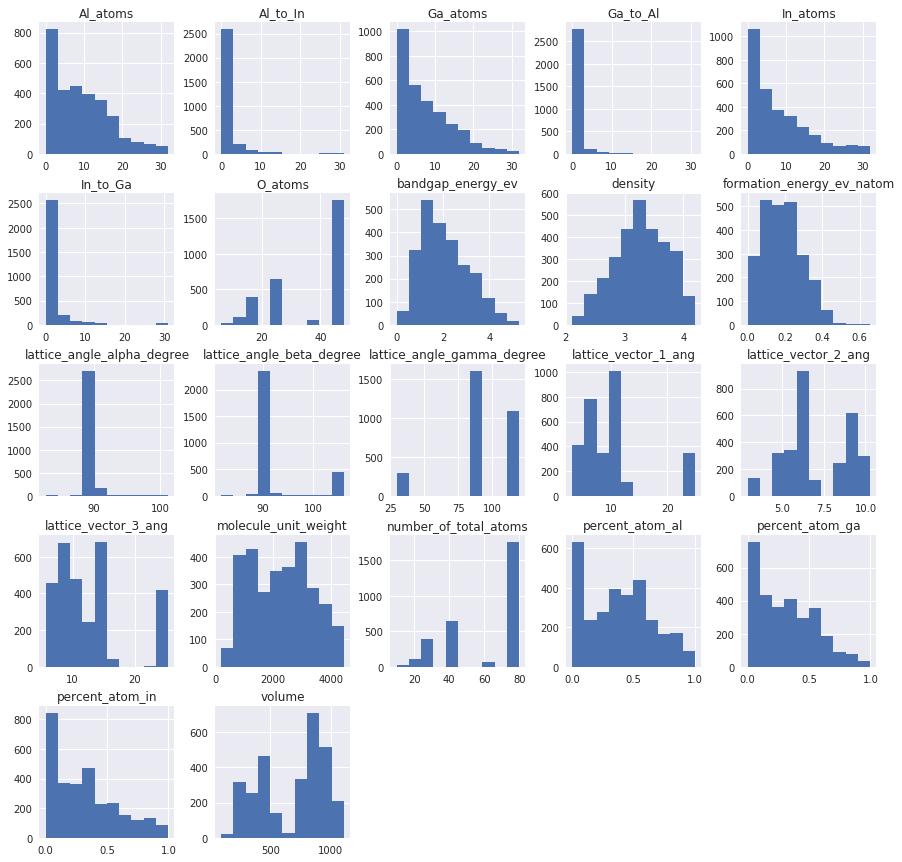

In [7]:
### Data Distribution
axis = merged.loc[:, merged.dtypes != 'object'].hist(figsize = (15, 15)) # most of them don't have distribution similar to normal distrib

In [8]:
# perform boxcox
# only to invert bandgap_energy_boxcox to bandgap_energy_ev
def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

# transform density
lmbda = boxcox(merged.loc[:(len(train)-1),'density'].dropna())[1]
merged['density'] = boxcox(merged['density'], lmbda = lmbda)

## we'll add 2 and 1, to avoid logarithmic conversin of negative values
merged.loc[:len(train)-1, 'bandgap_energy_boxcox'] = boxcox(merged.loc[:len(train)-1,'bandgap_energy_ev'])[0] +2
merged.loc[:len(train)-1, 'formation_energy_boxcox'] = boxcox(merged.loc[:len(train)-1,'formation_energy_ev_natom']+ 1)[0]

Before predicting we'll drop columns (bandgap_energy_ev, formation_energy_ev_natom, percent_atoms, number_of_total_atoms),  as they will be highly correlated with other features.


In [9]:
## drop columns
merged.drop(['percent_atom_in', 'percent_atom_ga', 'percent_atom_al', 'bandgap_energy_ev', 'formation_energy_ev_natom', 'number_of_total_atoms'], axis =1, inplace =True) # remove highly correlated features

# Correlation
We'll check which features are important.

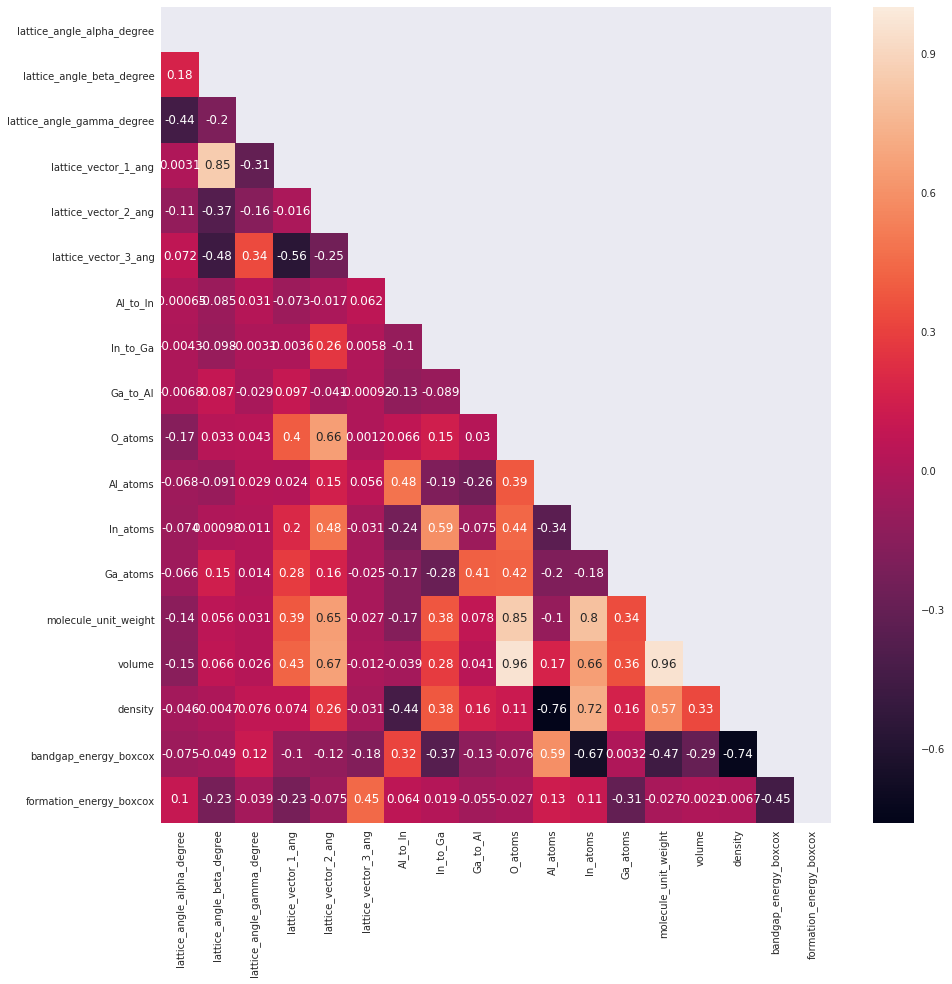

In [10]:
## correlation
corr_b = merged.corr()
mask = np.zeros_like(corr_b, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = pyplot.subplots(figsize=(15, 15))
g= sns.heatmap(corr_b, ax= ax, mask= mask, annot=True)

Let's take a look at the following features:
* **bandgap_energy_boxcox** - density, In_atoms, Al_atoms, molecule_unit_weight ahe highly correlated.
* **formation_energy_boxcox** -  bandgap_energy_boxcox is the most, however poorly correlated feature. Due to that we'll firstly predict **bandgap_energy_boxcox** adn use it as additional feature for predicting **formation_energy_boxcox**.
* **O-atoms, Ga_to_Al** -  are not correlated with output variables, and correlated with another important features. We'll remove them.

# Plot it!
I've examined many plots, so I'll show below those, which seems to be most interresting.

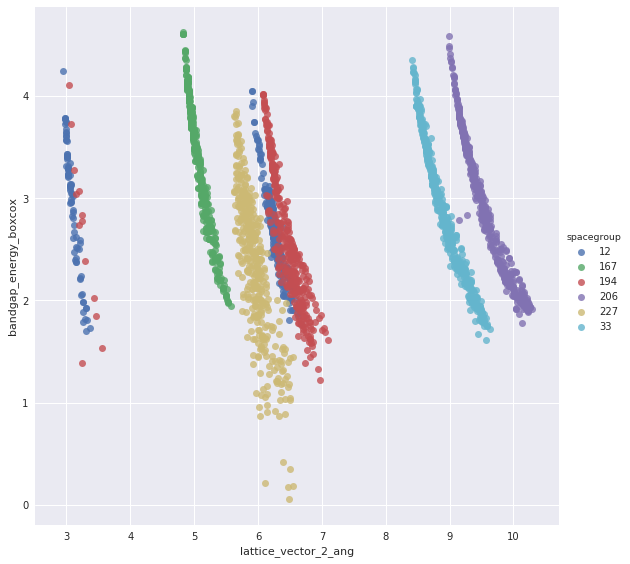

In [11]:
# remove highly correlated features
merged.drop(['O_atoms', 'Ga_to_Al'], axis=1, inplace =True)
# we should deffinitelly create some pattern to 
pl2 = sns.lmplot( x="lattice_vector_2_ang", y="bandgap_energy_boxcox", data=merged.loc[:len(train)-1, :], fit_reg=False, hue='spacegroup', legend=True, size = 8)

What a beautifull place for regression! We  can notice that:
* feature `194` and `12` will be separated into subclasses. Especially `194` to the right might be separated into two subclasses, but data are overlapping and we don't know the cause. Should be further examined based on domain knowledge.
* `206` has two outliers and `194` to the right has one, they will be remove
* `227` has **heteroscedasticity**

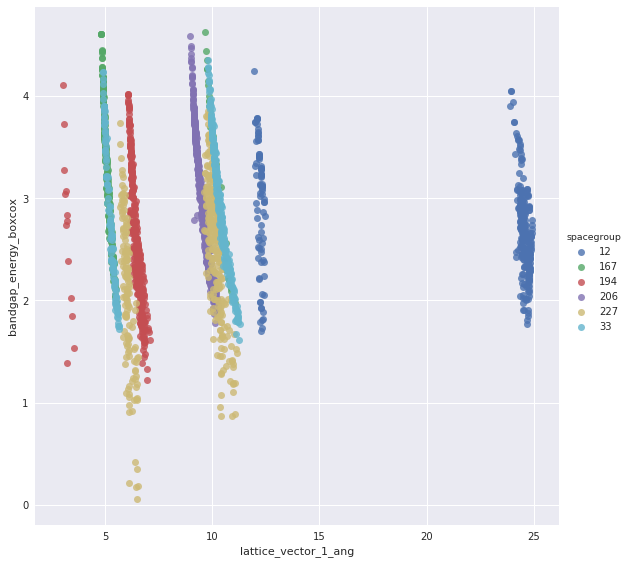

In [12]:
pl1 =sns.lmplot( x="lattice_vector_1_ang", y="bandgap_energy_boxcox", data=merged.loc[:len(train)-1, :], fit_reg=False, hue='spacegroup', legend=True, size = 8)

We will also separate `227` into 2 subclasses (they seem to have less heteroscedasticity than on the prevoius chart). As we have only 6 `spacegroups`, we'll  check if `spacegroup_label` has impact on results. As you can see below `spacegroup` is more complex, so `spacegroup_label` will be removed.

In [13]:
print("Frequency of given labels:")
pd.crosstab(index=merged["spacegroup"],columns=merged["spacegroup_label"])

Frequency of given labels:


spacegroup_label,cubic,hexagonal,monoclinic,orthorhombic,trigonal
spacegroup,,,,,
12,0,0,455,0,0
167,0,0,0,0,461
194,0,443,0,0,0
206,616,0,0,0,0
227,486,0,0,0,0
33,0,0,0,539,0


The plot below show that `lattice_angles` are not invormative (observation with angle 120 could take any value in range). We will also remove them.

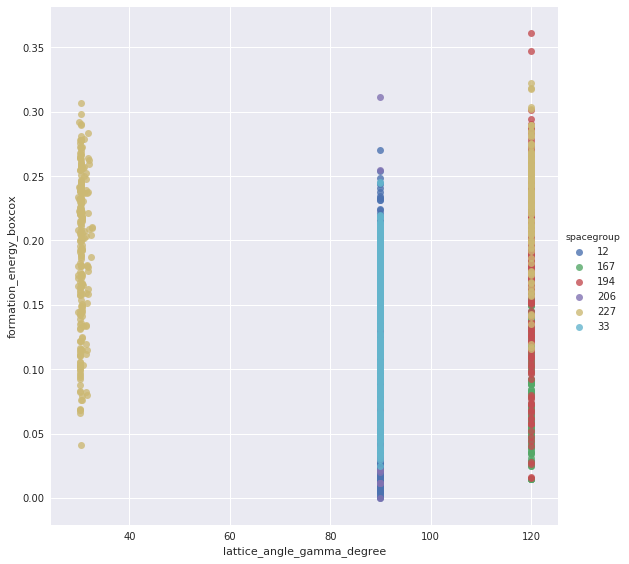

In [14]:
pl1 =sns.lmplot( x="lattice_angle_gamma_degree", y="formation_energy_boxcox", data=merged.loc[:len(train)-1, :], fit_reg=False, hue='spacegroup', legend=True, size = 8)

In [15]:
merged.drop(['spacegroup_label', 'lattice_angle_gamma_degree', 'lattice_angle_beta_degree', 'lattice_angle_alpha_degree'], axis=1, inplace =True)
# remove outliers and create new features based on charts:
for s in merged.index:
    if (merged['spacegroup'][s] == '194' and merged['lattice_vector_3_ang'][s] > 15):
        merged['spacegroup'][s] = '194_other' 
    elif (merged['spacegroup'][s] == '12' and merged['lattice_vector_2_ang'][s] < 5):
        merged['spacegroup'][s] = '12_other'
    elif (merged['spacegroup'][s] == '227' and merged['lattice_vector_1_ang'][s] < 7.5):
        merged['spacegroup'][s] = '227_other'
merged.drop([1983, 1378, 307], axis=0, inplace =True)
spacegroup = merged['spacegroup'] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Prediction 
As computation takes longer than 3600 sec (kernel is killed), I'll only describe further process.

**Formation_energy** is highly correlated with **bandgap_energy**,  so I've firstly predicted bandgap_energy and used it as additional feature to train formation_energy.

Dataset was converted into dummy variables and splitted into train and test set.
I've used  **xgboost** and **LightGBM**. Parameters were chosen using [this](https://github.com/SylwiaOliwia2/xgboost-AutoTune) library.

In [16]:
# define metric
def rmsle(y_true, y_pred): 
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())   

# create train, validation, test set
merged = pd.get_dummies(merged)
X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(merged.loc[:len(train)-1, merged.columns.difference(['formation_energy_boxcox', 'bandgap_energy_boxcox'])],
                                                      merged.loc[:len(train)-1, 'bandgap_energy_boxcox'], test_size=0.22, stratify = spacegroup[:len(merged)-len(test)], random_state=42)
X_test_b = merged.loc[len(train):, merged.columns.difference(['formation_energy_boxcox', 'bandgap_energy_boxcox'])]
y_test_b = merged.loc[len(train):, 'bandgap_energy_boxcox']

Don't forget to apply **invboxcox** to your predictions. 

In the code below replace **bandgap_energy_boxcox** and **formation_energy_boxcox** with your predictions.

In [17]:
# invert box cox
bandgap = invboxcox(merged.loc[len(train):,'bandgap_energy_boxcox']-2, boxcox(train.loc[:(len(train)-1),'bandgap_energy_ev'].dropna())[1])
formation = invboxcox(merged.loc[len(train):,'formation_energy_boxcox'], boxcox(train.loc[:len(train)-1,'formation_energy_ev_natom']+ 1)[1]) -1

bandgap.index = np.arange(600)
formation.index = np.arange(600)

#######################################
# final submission
submission = pd.DataFrame()
submission['id'] = test.index
submission['formation_energy_ev_natom'] = formation
submission['bandgap_energy_ev'] =bandgap
submission.to_csv('submission.csv',index=False)

Using averate of xgboost and LightGBM I've got **0.0589** score on public leaderboard (top 70%).